# Homework 3, Feb 2025

1) Plot the number of days with positive temperature (in Celsius) in Stockholm from 1756 till this year. Download the data file `stockholm_daily_mean_temperature.csv` from https://bolin.su.se/data/stockholm-historical-daily-temperature-2?n=stockholm-historical-temps-daily-2 . Note that some dates in which data is missing have very negative temperature. 


2) Write a Python program that simulates and plots the distance reached by a 2D random walker after $N$ steps, where $N$ ranges from 0 to 1000. The walker moves in discrete steps chosen from the set of `moves=[[0,1],[0,-1],[1,0],[-1, 0]]`, corresponding to up, down, right, and left. Theoretically, the expected distance after $N$ steps is $\frac{\sqrt{\pi}}{2}\sqrt{N}$. However, a single random walker will rarely match this distance exactly. To see how the average behavior approaches this theoretical curve, simulate $N_{walk}=1000$ random walkers, each taking up to 1000 steps. Compute and plot the average distance at each step $N$ over all walkers. Show that the averaged distance curve approximates $\frac{\sqrt{\pi}}{2}\sqrt{N}$ when $N_{walk}$ is large.

## Problem 1 - Stockholm Temperature

In [89]:
from numpy import array, loadtxt, zeros, arange, polyfit, random, pi, sqrt
from numba import njit

In [74]:
# Extract data from the file - without numpy

input_file = "stockholm_daily_mean_temperature.csv"

# The date is in the 1st column and the termperature is in the 2,3,4th columns

with open(input_file) as f:
    lines = f.readlines()
    # Remove the first line (It has the headers)
    lines = lines[1:]
    
    # Each line in the file is a string, with each set of information seperated by a comma
    lines = [line.split(",") for line in lines]
    
    
dates = [lines[i][0].split("-") for i in range(len(lines))]
temoperatures = [val[3] for val in lines]


In [75]:
# Extract data from the file using numpy

input_file = "stockholm_daily_mean_temperature.csv"

temperatures = loadtxt(input_file, delimiter=",", skiprows=1, usecols=(3))

dates = loadtxt(input_file, delimiter=",", skiprows=1, usecols=(0), dtype=str)
dates = array([date.split("-") for date in dates], dtype=int)

# It is indeed faster to use numpy loadtxt!

In [76]:
# I know that in class, we discuessed that a step of 365 days is a good approximation of a year with `histogram()`
# But I want to be more precise, so I am looping over the dataset to find the first instance of a year change

#This loops over all the temperatures and increases the positive count for the year, the year is incremented for any change detected in the year number

@njit #USING NUMBA FOR SPEEDUP
def filldata(dates, temperatures, positive_temperatures):
    years_accounted = 1  # The number of distinct years accounted for
    for i in range(len(dates)):
        if dates[i][0] == 1756 + years_accounted:
            years_accounted += 1
        if temperatures[i] > 0:
            positive_temperatures[years_accounted-1] += 1
    return positive_temperatures



In [77]:
# Initialize array for year start indices (1756 to 2024 - 270)
positive_temperatures = zeros(2026 - 1756, dtype=int)
filldata(dates, temperatures, positive_temperatures) # Filling the data for number of days with positive temperature each year
len(positive_temperatures)

270

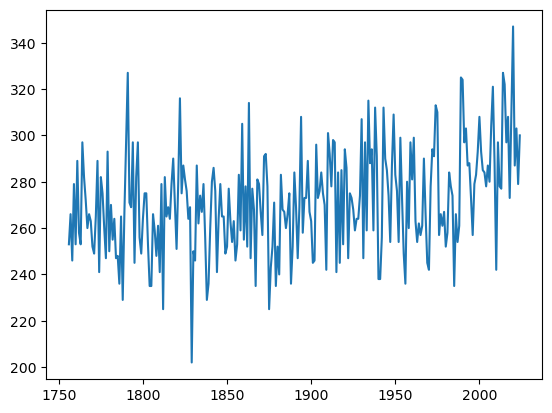

In [78]:
# Now I want to plot the data
import matplotlib.pyplot as plt


plt.plot(range(1756, 2025), positive_temperatures[:-1])  
plt.show()

### NOTE
WE WERE NOT ASKED TO FIND THE LINEAR FIT, BUT I DID IT ANYWAY TO CLEARLY SEE THE CHANGE OVER THE YEARS
THE CODE FOR THE FITTING WAS TAKEN FROM A SIMPLE SEARCH FOR "lINEAR FIT NUMPY"

The only addition to the previous plot that I made is:

```
slope, intercept = polyfit(x, positive_temperatures[:-1], 1)
fitted_line = slope * x + intercept
```

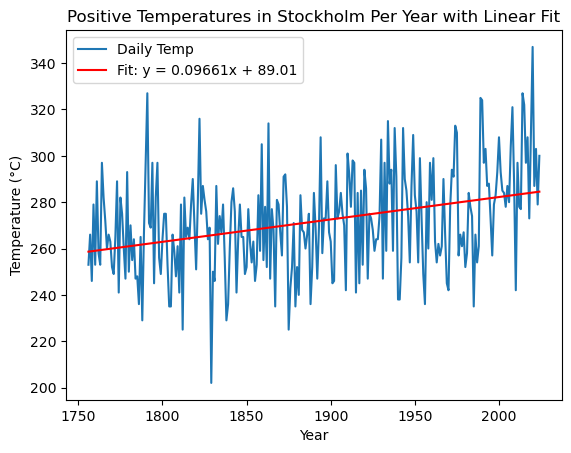

In [79]:
# x-axis: Year
x = arange(1756, 2025)  # 269 points
# Linear fit
slope, intercept = polyfit(x, positive_temperatures[:-1], 1)
fitted_line = slope * x + intercept

# Plot
plt.plot(x, positive_temperatures[:-1], label="Daily Temp")
plt.plot(x, fitted_line, color="red", label=f"Fit: y = {slope:.5f}x + {intercept:.2f}")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Positive Temperatures in Stockholm Per Year with Linear Fit")
plt.legend()
plt.show()



### Another Note
Since 2025 data is only limited to a few days, (a few dozen), it is an outlier. Hence, it skewed the entire plot. Hence, **I only plotted the data up until 2024**.

---

# Problem 2 - Random Walker

In [80]:
# Defining Initial Parameters
Nwalkers = 1000
stepsPerWalker = 1000
moves = array([[0, 1], [1, 0], [0, -1], [-1, 0]])

In [81]:
@njit  
def norm(x):
    return (x**2).sum()**0.5

In [82]:
# The way I would approach this is, for each step, I would increment the position of the walker by a random step
# I would keep an array that accounts for the average distance of the walkers at each step.
# This way I don't need to store all the positions for each steps, just the average distances of each step and the final positions after n iterations

@njit # USING NUMBA FOR SPEEDUP
def randomWalk(walkerPositions, averageDistance, moves, stepsPerWalker, Nwalkers):
    for i in range(stepsPerWalker):
        for j in range(Nwalkers):
            walkerPositions[j] += moves[random.randint(4)] # Increment the position of the walker by a random step
            averageDistance[i] += norm(walkerPositions[j]) # Sum over all walker distances
        averageDistance[i] /= Nwalkers # Divide by the number of walkers to get the average distance

In [87]:
#Initialization and Calling the function
walkerPositions = zeros((Nwalkers, 2))
averageDistance = zeros(stepsPerWalker)

randomWalk(walkerPositions, averageDistance, moves, stepsPerWalker, Nwalkers)

# Printing the first 10 values for the average distance to confirm
print(averageDistance[:10])

[1.         1.21607734 1.6069419  1.77947146 2.05977457 2.18705871
 2.38394462 2.53215533 2.76144087 2.91734384]


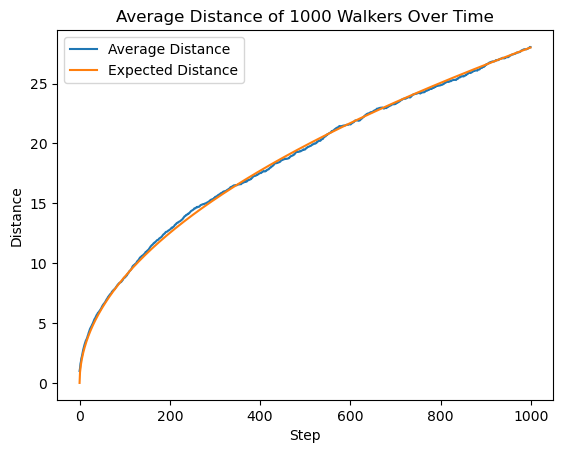

In [92]:
# Plotting the average distance

@njit
def expectedDistance(N):
    return sqrt(pi*N)/ 2

# Plotting the expected distance
plt.plot(averageDistance, label="Average Distance")
plt.plot(expectedDistance(arange(stepsPerWalker)), label="Expected Distance")
plt.xlabel("Step")
plt.ylabel("Distance")
plt.title(f"Average Distance of {Nwalkers} Walkers Over Time")
plt.legend()
plt.show()